In [1]:
import sys

# The path of COT package
sys.path.append("./")

from COT import COT

In [2]:
## Download GSE28490

import GEOparse

gse = GEOparse.get_GEO(geo="GSE28490", destdir="./", silent=True)

C:\Users\cbil\miniconda3\lib\site-packages\GEOparse\GEOparse.py:110: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath, open_kwargs=open_kwargs)


In [3]:
## Select needed cell types

cellTypes = {"Neutrophils": [], "NK": [], "CD19+ B": [], "CD8+ T": [], "CD14+ monocytes": []}

sampleType = [] # cell type labels
for cell in cellTypes:
    for gsm in gse.phenotype_data.index.values:
        if cell in gse.phenotype_data["source_name_ch1"][gsm]:
            cellTypes[cell].append(gsm)
            sampleType.append(cell)
            
samples = [] # sample ID
for cell in cellTypes:
    samples = samples + cellTypes[cell]   
    
data = gse.pivot_samples('VALUE')[samples] # selected raw data

In [4]:
## Compute COT cosine value

cot = COT(df_raw=data, logarithmic_data=True)
cot.generate_subtype_means(sampleType)
cot.generate_cos_values()

COT: package initiated.
COT: subtype means generated.
COT: cos values generated.


In [5]:
## Estimate p-value

cot.estimate_p_values()

COT: estimating p-values ...
COT: iteration 1: 42.7021 seconds
COT: iteration 2: 17.0497 seconds
COT: iteration 3: 19.6499 seconds
COT: iteration 4: 18.5045 seconds
COT: iteration 5: 15.4116 seconds
COT: iteration 6: 15.2236 seconds
COT: p-values estimated.


COT: subtype markers generated.


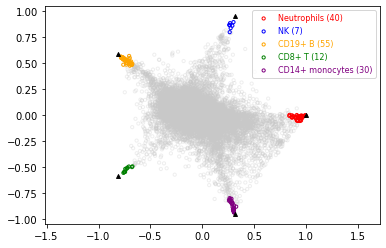

In [6]:
## Obtain and plot the subtype markers on the simplex (the same one on the manuscript)

cot.obtain_subtype_markers(top=144)
cot.plot_simplex()

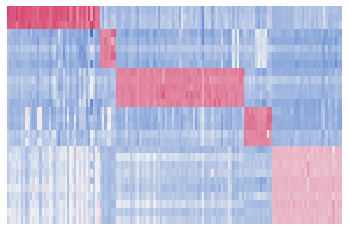

In [7]:
## plot heatmap of subtype markers

cot.plot_heatmap()

COT: package initiated.
COT: subtype means generated.
COT: cos values generated.
COT: estimating p-values ...
COT: iteration 1: 18.3131 seconds
COT: iteration 2: 17.1193 seconds
COT: iteration 3: 19.6463 seconds
COT: iteration 4: 19.1566 seconds
COT: iteration 5: 15.8487 seconds
COT: iteration 6: 15.2620 seconds
COT: p-values estimated.
COT: subtype markers generated.


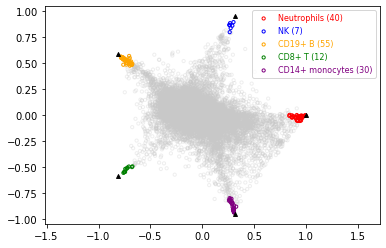

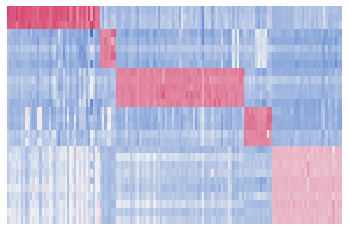

COT: pipeline completed.


In [8]:
## or, use the COT pipeline

cot_pl = COT(df_raw=data, logarithmic_data=True)
cot_pl.cot_pipeline(subtype_label=sampleType, top=144)

In [9]:
## Compare OVO T-Test

import numpy as np
import pandas as pd


# Take log of the raw data
df_log = np.log2(cot.df_raw)

# Prepare to compute the t-statistics for every pair of subtypes
mean = df_log.apply(
        lambda x: np.array([np.mean(x[col]) 
            for col in cot.subtypes.values()]), axis=1)
var = df_log.apply(lambda x: np.array([np.var(x[col], ddof=1) for col in cot.subtypes.values()]), axis=1)
n = df_log.apply(lambda x: np.array([len(col) for col in cot.subtypes.values()]), axis=1)

# Find and compute the subtype with the highest t-statistics
idx = mean.apply(lambda x: np.argmax(x))
# The empty column 'score' and 'score_subtype' are prepared for other methods comparing with COT 
cot.df_cos['score'] = pd.DataFrame({'mean': mean, 'n': n, 'var': var, 'idx': idx}) \
        .apply(lambda x: (x['mean'][x['idx']] - x['mean']) / 
            np.sqrt(x['var'][x['idx']] / x['n'][x['idx']] + x['var'] / x['n']), axis=1) \
                .apply(lambda x: np.sort(x)).apply(lambda x: x[1])
cot.df_cos['score_subtype'] = idx.apply(lambda x: list(cot.subtypes.keys())[x])

COT: subtype markers generated.


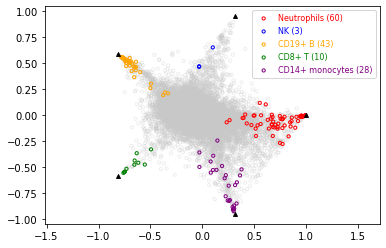

In [10]:
## Obtain and plot the subtype markers from OVO t-test on the simplex (the same one on the manuscript)
# The 'scoreThre' is the threshold for 'score' column (higher better)
# When 'scoreThre' is not None, cosThre, pThre, and qThre are invalid automatically
cot.obtain_subtype_markers(top=144, scoreThre=0)
cot.plot_simplex()

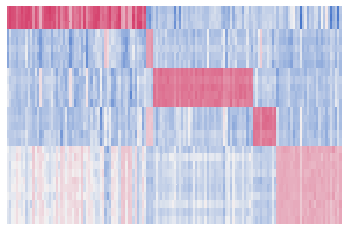

In [11]:
## plot heatmap of subtype markers from OVO t-test
cot.plot_heatmap()